### Passo 1: Upload dos Arquivos Essenciais

Para começar, precisamos de dois arquivos no nosso ambiente:
1.  **`kaggle.json`**: Sua chave de API do Kaggle para podermos baixar o dataset.
2.  **`emotions.keras`**: O arquivo do seu modelo treinado.

A célula de código abaixo irá abrir dois campos de upload para você enviar esses arquivos do seu computador.

In [1]:
# Célula 1: Uploads
from google.colab import files
import os

print("--- Por favor, faça o upload do seu arquivo kaggle.json ---")
files.upload()

# Configurar a API do Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
print("\nAPI do Kaggle configurada.")

print("\n--- Agora, por favor, faça o upload do seu arquivo emotions.keras ---")
files.upload()
print("\nModelo 'emotions.keras' recebido.")

--- Por favor, faça o upload do seu arquivo kaggle.json ---


Saving kaggle.json to kaggle.json

API do Kaggle configurada.

--- Agora, por favor, faça o upload do seu arquivo emotions.keras ---


Saving emotion_model.keras to emotion_model.keras

Modelo 'emotions.keras' recebido.


### Passo 2: Baixar e Descompactar o Dataset

Com a API do Kaggle configurada, vamos baixar o dataset "Facial Emotion Recognition" e descompactá-lo no diretório `/content/`.

In [2]:
# Célula 2 (CORRIGIDA com o dataset público correto)

# O -p /content/ garante que o zip seja salvo no diretório principal
# --unzip descompacta automaticamente
!kaggle datasets download -d fahadullaha/facial-emotion-recognition-dataset -p /content/ --unzip

# Verificação para garantir que o download funcionou
import os
# O nome da pasta principal dentro desse dataset é 'train' ou 'processed_data'
# Vamos checar por uma pasta conhecida
if os.path.exists('processed_data') or os.path.exists('train'):
    print("\nDataset baixado e descompactado com sucesso!")
else:
    print("\nERRO: O download falhou ou a estrutura de pastas não é a esperada.")

Dataset URL: https://www.kaggle.com/datasets/fahadullaha/facial-emotion-recognition-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
 61% 123M/200M [00:00<00:00, 1.28GB/s]
100% 200M/200M [00:00<00:00, 784MB/s] 

Dataset baixado e descompactado com sucesso!


### Passo 3: Carregar Modelo e Preparar Dados de Validação

Agora que todos os arquivos estão no lugar, esta célula irá realizar duas tarefas principais:

1.  **Carregar o Modelo:** O arquivo `emotions.keras` que você enviou será carregado na memória, pronto para fazer previsões.
2.  **Preparar o DataFrame de Validação:** Vamos ler os caminhos de todas as imagens do dataset que acabamos de descompactar e, em seguida, separaremos 20% delas para validação. Isso garante que estamos testando o modelo em um conjunto de dados que ele nunca viu, nos dando uma medida real de seu desempenho.

In [3]:
# Célula 3: Carregar modelo e preparar dados
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Silencia avisos do TensorFlow

import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Caminhos no ambiente Colab
MODEL_PATH = 'emotion_model.keras'
# A pasta principal dentro do zip pode ser 'train' ou 'processed_data'
# Vamos criar uma lógica para encontrar a pasta correta
if os.path.exists('processed_data'):
    DATASET_BASE_DIR = 'processed_data'
elif os.path.exists('train'):
    DATASET_BASE_DIR = 'train'
else:
    raise FileNotFoundError("Pasta do dataset ('processed_data' ou 'train') não encontrada.")

# Carregar o modelo
model = tf.keras.models.load_model(MODEL_PATH)

# Preparar o DataFrame de validação
filepaths = []
labels = []
folds = os.listdir(DATASET_BASE_DIR)
for fold in folds:
    foldpath = os.path.join(DATASET_BASE_DIR, fold)
    if not os.path.isdir(foldpath): continue

    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

df = pd.DataFrame({'filepath': filepaths, 'label': labels})
_, valid_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=42, stratify=df['label'])

print("Modelo e DataFrame de validação prontos.")

Modelo e DataFrame de validação prontos.


### Passo 4: Análise de Erros com Matriz de Confusão

Esta é a célula principal da nossa análise. Vamos criar um gerador de imagens para o nosso conjunto de validação, usar o modelo para prever a emoção de cada uma, e então gerar duas visualizações cruciais:

1.  **Relatório de Classificação:** Mostra as métricas de `precision`, `recall` e `f1-score` para cada emoção. Ele nos dirá numericamente o quão bem o modelo se sai em cada classe.
2.  **Matriz de Confusão:** A ferramenta visual para testar sua hipótese. Ela nos mostrará exatamente quais emoções estão sendo confundidas umas com as outras (ex: quantos `sad` foram classificados como `happy`).

Found 9956 validated image filenames belonging to 7 classes.

Fazendo predições no conjunto de validação...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


156/156 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step

--- Relatório de Classificação ---
              precision    recall  f1-score   support

       angry       0.52      0.33      0.40      1184
     disgust       0.50      0.87      0.64      1184
        fear       0.43      0.06      0.10      1184
       happy       0.81      0.81      0.81      2280
     neutral       0.54      0.56      0.55      1633
         sad       0.42      0.52      0.47      1307
    surprise       0.65      0.76      0.70      1184

    accuracy                           0.59      9956
   macro avg       0.55      0.56      0.52      9956
weighted avg       0.58      0.59      0.56      9956



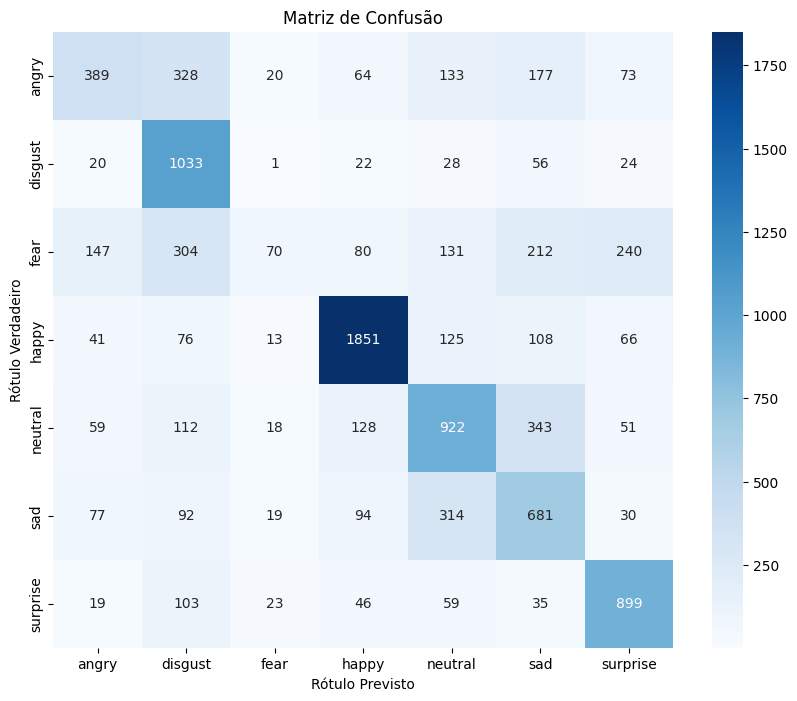

In [ ]:
# Célula 4: Predições e Análise
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (48, 48)
BATCH_SIZE = 64

valid_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False # Essencial!
)

print("\nFazendo predições no conjunto de validação...")
predictions = model.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Gerar Relatório e Matriz
print("\n--- Relatório de Classificação ---")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Matriz de Confusão')
plt.ylabel('Rótulo Verdadeiro')
plt.xlabel('Rótulo Previsto')
plt.show()

# Notebook 2.1: Retreinamento com Rebalanceamento Agressivo

**Objetivo:** Retreinar nosso modelo CNN original do zero, mas utilizando um dicionário de pesos de classe (`class_weight`) manual e agressivo. A meta é forçar o modelo a prestar muito mais atenção às classes com baixo desempenho, como 'fear' e 'angry'.

### Passo 1: Setup e Preparação dos Dados

Esta etapa é idêntica à do nosso primeiro notebook de treinamento. Precisamos carregar o dataset, criar os DataFrames e dividi-los em conjuntos de treino e validação. Também vamos criar os geradores de imagem.

In [5]:
# Célula 1: Setup Completo
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import files

# --- 1. Upload da API Key (se necessário) ---
if not os.path.exists('/root/.kaggle/kaggle.json'):
    print("--- Por favor, faça o upload do seu arquivo kaggle.json ---")
    files.upload()
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    print("\nAPI do Kaggle configurada.")

# --- 2. Download e Descompactação do Dataset (se necessário) ---
if not os.path.exists('processed_data'):
    print("\n--- Baixando e descompactando o dataset ---")
    !kaggle datasets download -d fahadullaha/facial-emotion-recognition-dataset -p /content/ --unzip
    print("\nDataset pronto.")

# --- 3. Preparação dos DataFrames ---
DATASET_BASE_DIR = 'processed_data' if os.path.exists('processed_data') else 'train'
filepaths = []
labels = []
folds = os.listdir(DATASET_BASE_DIR)
for fold in folds:
    foldpath = os.path.join(DATASET_BASE_DIR, fold)
    if os.path.isdir(foldpath):
        filelist = os.listdir(foldpath)
        for file in filelist:
            filepaths.append(os.path.join(foldpath, file))
            labels.append(fold)

df = pd.DataFrame({'filepath': filepaths, 'label': labels})
train_df, valid_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=42, stratify=df['label'])

# --- 4. Criação dos Geradores ---
IMG_SIZE = (48, 48)
BATCH_SIZE = 64

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df, x_col='filepath', y_col='label', target_size=IMG_SIZE,
    color_mode='grayscale', class_mode='categorical', batch_size=BATCH_SIZE
)
valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df, x_col='filepath', y_col='label', target_size=IMG_SIZE,
    color_mode='grayscale', class_mode='categorical', batch_size=BATCH_SIZE, shuffle=False
)

print("\nGeradores 'train_generator' e 'valid_generator' foram criados com sucesso!")

Found 39823 validated image filenames belonging to 7 classes.
Found 9956 validated image filenames belonging to 7 classes.

Geradores 'train_generator' e 'valid_generator' foram criados com sucesso!


### Passo 2: Definindo os Pesos Agressivos

Aqui está a nova parte. Com base na nossa análise (matriz de confusão), sabemos quais classes precisam de mais ajuda. As classes são ordenadas alfabeticamente pelos geradores: `angry`, `disgust`, `fear`, `happy`, `neutral`, `sad`, `surprise`.

* **Lembrete do `recall`:** `fear` (6%), `angry` (34%), `sad` (54%), `neutral` (57%).
* **Nossa Estratégia:** Vamos atribuir pesos inversamente proporcionais a esses resultados. Quanto pior o desempenho, maior o peso.

**Importante:** Estes números são uma primeira tentativa, uma hipótese. Achar os pesos perfeitos é um processo de experimentação!

In [ ]:
# Célula 2: Dicionário de Pesos Manuais
# Ordem das classes: 0:angry, 1:disgust, 2:fear, 3:happy, 4:neutral, 5:sad, 6:surprise

class_weights = {
    0: 5.0,  # angry (recall baixo, peso alto)
    1: 1.0,  # disgust (recall bom, peso normal)
    2: 10.0, # fear (recall péssimo, peso MÁXIMO)
    3: 0.7,  # happy (recall ótimo, peso baixo)
    4: 2.0,  # neutral (recall mediano, peso médio)
    5: 2.5,  # sad (recall mediano, peso médio-alto)
    6: 1.2   # surprise (recall bom, peso normal)
}

print("Dicionário de pesos de classe customizado:", class_weights)

Dicionário de pesos de classe customizado: {0: 5.0, 1: 1.0, 2: 10.0, 3: 0.7, 4: 2.0, 5: 2.5, 6: 1.2}


### Passo 3: Re-treinar o Modelo com os Novos Pesos

Agora, simplesmente recriamos a mesma arquitetura do nosso primeiro modelo e o treinamos do zero, mas desta vez passamos o nosso novo dicionário `class_weights` para o método `model.fit()`.

In [ ]:
# Célula 3: Recriar e treinar o modelo
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Recriamos a mesma arquitetura do nosso primeiro modelo de sucesso
model = Sequential([
    Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(48, 48, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.2),

    Conv2D(64, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),

    Conv2D(128, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.4),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# --- Callbacks com PATIENCE definidos ---
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=15, # <<< Paciência para parar o treino
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=5,  # <<< Paciência para reduzir a taxa de aprendizado
    verbose=1
)

# Treinamento com os novos pesos e os callbacks
history = model.fit(
    train_generator,
    epochs=300, # Um número alto, pois o EarlyStopping irá parar antes
    validation_data=valid_generator,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/300
623/623 ━━━━━━━━━━━━━━━━━━━━ 53s 73ms/step - accuracy: 0.1616 - loss: 6.0679 - val_accuracy: 0.1306 - val_loss: 5.5174 - learning_rate: 0.0010
Epoch 2/300
623/623 ━━━━━━━━━━━━━━━━━━━━ 38s 61ms/step - accuracy: 0.1988 - loss: 4.3478 - val_accuracy: 0.4116 - val_loss: 1.5721 - learning_rate: 0.0010
Epoch 3/300
623/623 ━━━━━━━━━━━━━━━━━━━━ 39s 62ms/step - accuracy: 0.2529 - loss: 4.0640 - val_accuracy: 0.4411 - val_loss: 1.4492 - learning_rate: 0.0010
Epoch 4/300
623/623 ━━━━━━━━━━━━━━━━━━━━ 40s 64ms/step - accuracy: 0.2881 - loss: 3.9262 - val_accuracy: 0.2402 - val_loss: 2.6493 - learning_rate: 0.0010
Epoch 5/300
623/623 ━━━━━━━━━━━━━━━━━━━━ 40s 64ms/step - accuracy: 0.3155 - loss: 3.8033 - val_accuracy: 0.4870 - val_loss: 1.3354 - learning_rate: 0.0010
Epoch 6/300
623/623 ━━━━━━━━━━━━━━━━━━━━ 38s 61ms/step - accuracy: 0.3373 - loss: 3.7329 - val_accuracy: 0.4287 - val_loss: 1.4926 - learning_rate: 0.0010
Epoch 7/300
623/623 ━━━━━━━━━━━━━━━━━━━━ 39s 62ms/step - accuracy: 0.3

### Passo 4: Avaliação do Modelo Rebalanceado

Após a conclusão do treinamento, esta célula irá analisar o desempenho do nosso novo modelo. Faremos três coisas:

1.  **Plotar as Curvas de Aprendizado:** Visualizaremos a evolução da acurácia e da perda (loss) ao longo das épocas para o treino e a validação, usando o objeto `history`.
2.  **Gerar o Relatório de Classificação:** Analisaremos as métricas de `precision`, `recall` e `f1-score` para cada emoção. Nosso objetivo é ver uma melhora significativa no `recall` das classes que tinham baixo desempenho, como 'fear' e 'angry'.
3.  **Gerar a Nova Matriz de Confusão:** Esta será a prova final. Compararemos esta matriz com a da nossa primeira análise para ver se a distribuição dos erros melhorou.

--- Curvas de Aprendizado ---


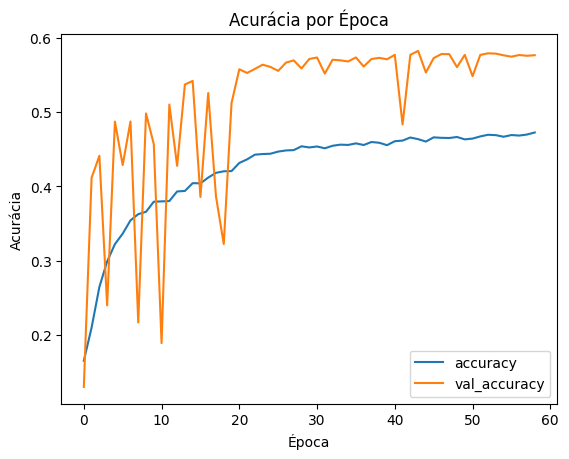

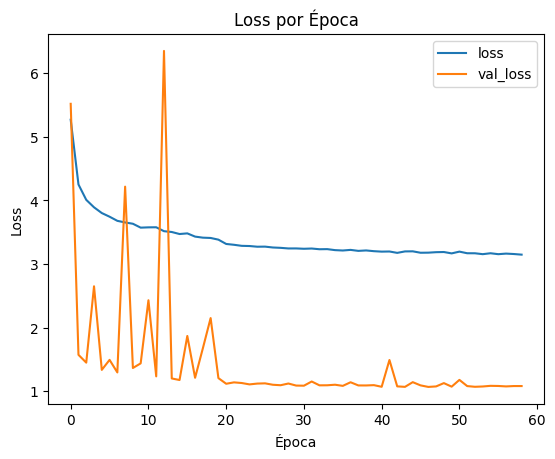


--- Fazendo predições no conjunto de validação... ---
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step

--- Relatório de Classificação ---
              precision    recall  f1-score   support

       angry       0.50      0.48      0.49      1184
     disgust       0.73      0.72      0.73      1184
        fear       0.31      0.68      0.43      1184
       happy       0.92      0.74      0.82      2280
     neutral       0.55      0.59      0.57      1633
         sad       0.49      0.34      0.40      1307
    surprise       0.86      0.39      0.54      1184

    accuracy                           0.58      9956
   macro avg       0.62      0.56      0.57      9956
weighted avg       0.65      0.58      0.59      9956


--- Matriz de Confusão ---


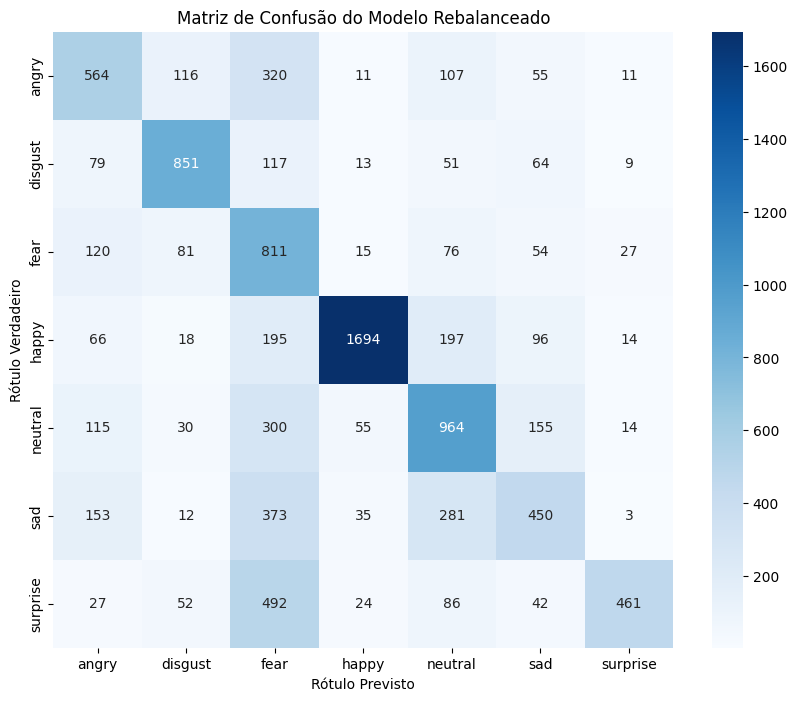

In [ ]:
# Célula 4: Avaliação completa do modelo rebalanceado
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

# 1. Plotar as Curvas de Aprendizado
print("--- Curvas de Aprendizado ---")
history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()
plt.title('Acurácia por Época')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.show()

history_df[['loss', 'val_loss']].plot()
plt.title('Loss por Época')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.show()

# 2. Fazer predições no conjunto de validação
print("\n--- Fazendo predições no conjunto de validação... ---")
predictions = model.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# 3. Gerar Relatório de Classificação e Matriz de Confusão
print("\n--- Relatório de Classificação ---")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

print("\n--- Matriz de Confusão ---")
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Matriz de Confusão do Modelo Rebalanceado')
plt.ylabel('Rótulo Verdadeiro')
plt.xlabel('Rótulo Previsto')
plt.show()

# Notebook 2.2: Tentativa de Melhoria com Transfer Learning (VGG16)

**Objetivo:** Após observarmos os limites da nossa CNN simples e do rebalanceamento agressivo, vamos agora aplicar uma técnica mais poderosa: o **Transfer Learning**. Utilizaremos a arquitetura VGG16, pré-treinada em milhões de imagens, como um extrator de características especialista.

**Estratégia:**
1.  Usaremos imagens com maior resolução (96x96) e em formato RGB, como esperado por modelos pré-treinados.
2.  Congelaremos o corpo principal do VGG16 e treinaremos apenas uma nova "cabeça" de classificação.
3.  Usaremos o rebalanceamento padrão (`'balanced'`) inicialmente, pois a riqueza das características extraídas pelo VGG16 pode, por si só, ajudar a diferenciar melhor as classes.

### Passo 1: Preparar Novos Geradores de Dados (RGB e 96x96)

Modelos como o VGG16 foram treinados com imagens coloridas (3 canais) e de maior resolução. Portanto, precisamos criar novos geradores de dados que preparem nossas imagens neste novo formato.

In [6]:
# Célula 1: Criar geradores para Transfer Learning
# Reutilizamos os DataFrames 'train_df' and 'valid_df' da etapa anterior.

IMG_SIZE_VGG = (96, 96) # Tamanho de imagem maior
BATCH_SIZE = 64

# Note o color_mode='rgb'
train_datagen_vgg = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
valid_datagen_vgg = ImageDataGenerator(rescale=1./255)

train_generator_vgg = train_datagen_vgg.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE_VGG,
    color_mode='rgb', # <<< MUDANÇA IMPORTANTE
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

valid_generator_vgg = valid_datagen_vgg.flow_from_dataframe(
    dataframe=valid_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE_VGG,
    color_mode='rgb', # <<< MUDANÇA IMPORTANTE
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

print("Novos geradores de dados (RGB, 96x96) prontos.")

Found 39823 validated image filenames belonging to 7 classes.
Found 9956 validated image filenames belonging to 7 classes.
Novos geradores de dados (RGB, 96x96) prontos.


### Passo 2: Construir o Modelo com a Base VGG16

Agora, o coração do Transfer Learning. Carregamos o VGG16 com os pesos aprendidos no ImageNet, removemos sua camada de classificação original e congelamos todo o seu corpo principal. Isso significa que usaremos o VGG16 como um extrator de características fixo.

In [7]:
# Célula 2: Construir o modelo VGG16
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout

# Carregar o modelo base sem a cabeça de classificação
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE_VGG[0], IMG_SIZE_VGG[1], 3)
)

# Congelar os pesos do modelo base
base_model.trainable = False

# Criar o novo modelo sequencial
model_vgg = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax') # Nossa camada de saída para 7 emoções
])

model_vgg.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 3, 3, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,896,391 (60.64 MB)

 Trainable params: 1,181,703 (4.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

### Passo 3: Treinar o Modelo de Transfer Learning

Com a arquitetura pronta, compilamos o modelo e iniciamos o treinamento. Desta vez, vamos usar o cálculo de pesos de classe padrão (`'balanced'`) para ver o quão bem o modelo se sai apenas com o poder das características do VGG16.

In [8]:
# Célula 3: Treinar o modelo VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight
import numpy as np

# Calcular pesos de classe padrão
class_weights_balanced = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)
class_weights_balanced_dict = {i : weight for i, weight in enumerate(class_weights_balanced)}


# Compilar o modelo
model_vgg.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1)

# Treinamento
history_vgg = model_vgg.fit(
    train_generator_vgg,
    epochs=300,
    validation_data=valid_generator_vgg,
    class_weight=class_weights_balanced_dict,
    callbacks=[early_stopping, reduce_lr]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/300
623/623 ━━━━━━━━━━━━━━━━━━━━ 145s 218ms/step - accuracy: 0.3423 - loss: 1.7064 - val_accuracy: 0.4613 - val_loss: 1.4044 - learning_rate: 0.0010
Epoch 2/300
623/623 ━━━━━━━━━━━━━━━━━━━━ 128s 205ms/step - accuracy: 0.4407 - loss: 1.4747 - val_accuracy: 0.4925 - val_loss: 1.3203 - learning_rate: 0.0010
Epoch 3/300
623/623 ━━━━━━━━━━━━━━━━━━━━ 129s 207ms/step - accuracy: 0.4628 - loss: 1.4285 - val_accuracy: 0.5126 - val_loss: 1.2753 - learning_rate: 0.0010
Epoch 4/300
623/623 ━━━━━━━━━━━━━━━━━━━━ 130s 209ms/step - accuracy: 0.4712 - loss: 1.3975 - val_accuracy: 0.5166 - val_loss: 1.2675 - learning_rate: 0.0010
Epoch 5/300
623/623 ━━━━━━━━━━━━━━━━━━━━ 128s 205ms/step - accuracy: 0.4769 - loss: 1.3819 - val_accuracy: 0.5137 - val_loss: 1.2785 - learning_rate: 0.0010
Epoch 6/300
623/623 ━━━━━━━━━━━━━━━━━━━━ 129s 207ms/step - accuracy: 0.4855 - loss: 1.3657 - val_accuracy: 0.5232 - val_loss: 1.2574 - learning_rate: 0.0010
Epoch 7/300
623/623 ━━━━━━━━━━━━━━━━━━━━ 134s 215ms/step -

### Passo 4: Avaliação Final do Modelo de Transfer Learning (VGG16)

Com o treinamento concluído, esta célula fará a análise completa do desempenho do nosso modelo `vgg`. O objetivo é verificar se a abordagem de Transfer Learning, com uma arquitetura mais profunda e imagens de maior resolução, conseguiu superar os problemas de confusão entre classes que vimos nos modelos anteriores. Vamos analisar:

1.  **As Curvas de Aprendizado:** Para ver se o treinamento foi estável.
2.  **O Relatório de Classificação:** Para medir o `recall` e a `precision` de cada emoção.
3.  **A Matriz de Confusão:** Para visualizar a performance e comparar diretamente com as matrizes dos modelos anteriores.

--- Curvas de Aprendizado ---


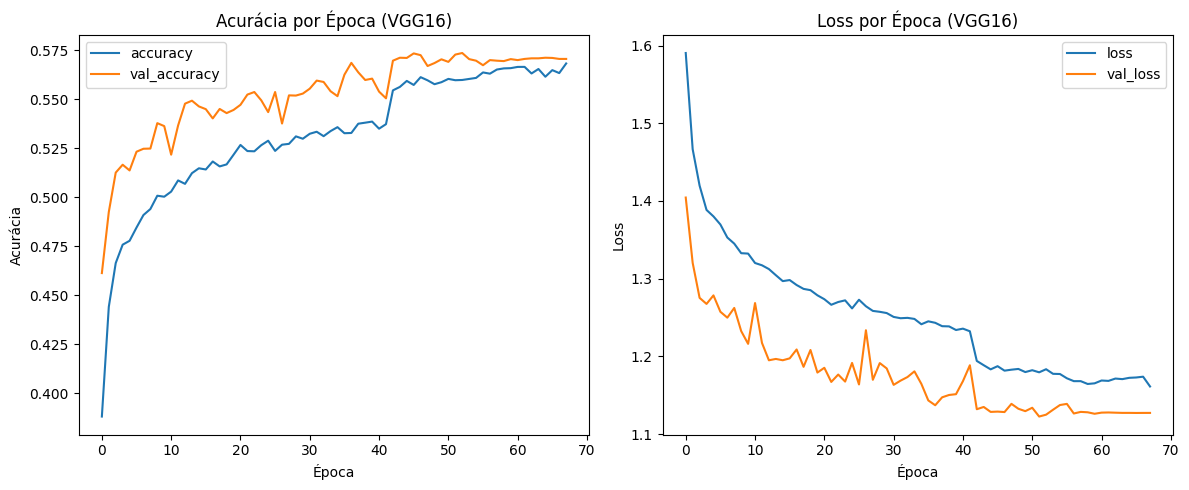


--- Fazendo predições no conjunto de validação... ---
156/156 ━━━━━━━━━━━━━━━━━━━━ 13s 82ms/step

--- Relatório de Classificação (VGG16) ---
              precision    recall  f1-score   support

       angry       0.49      0.34      0.40      1184
     disgust       0.68      0.81      0.74      1184
        fear       0.47      0.32      0.38      1184
       happy       0.78      0.69      0.73      2280
     neutral       0.47      0.66      0.55      1633
         sad       0.40      0.45      0.42      1307
    surprise       0.65      0.61      0.63      1184

    accuracy                           0.57      9956
   macro avg       0.56      0.56      0.55      9956
weighted avg       0.58      0.57      0.57      9956


--- Matriz de Confusão (VGG16) ---


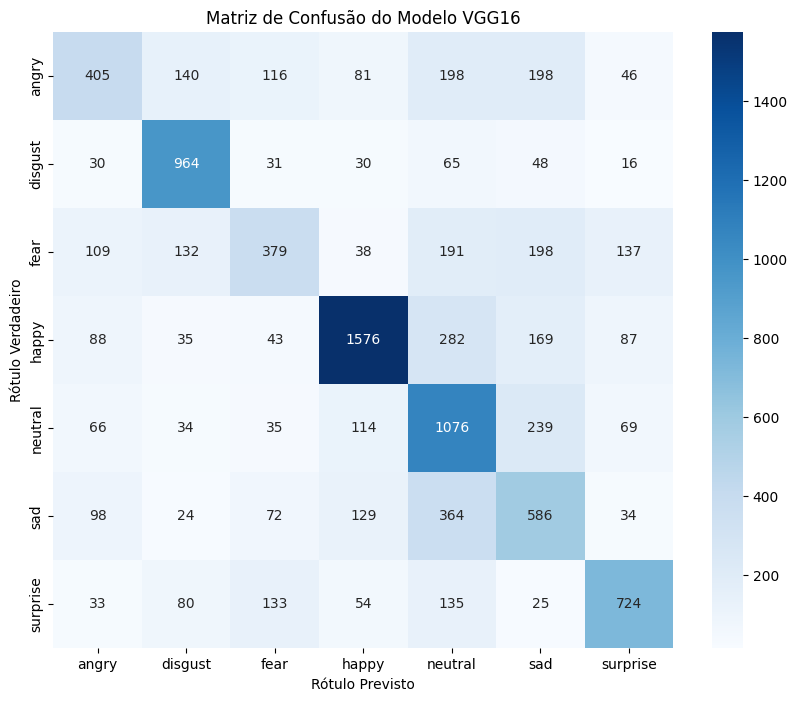

In [9]:
# Célula 4: Avaliação completa do modelo VGG16
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# (Opcional) Se o ambiente foi reiniciado, você pode carregar o melhor modelo salvo:
# from tensorflow.keras.models import load_model
# model_vgg = load_model('/content/drive/MyDrive/emotion_model_vgg_best.keras')


# 1. Plotar as Curvas de Aprendizado
print("--- Curvas de Aprendizado ---")
history_df_vgg = pd.DataFrame(history_vgg.history)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
history_df_vgg[['accuracy', 'val_accuracy']].plot(ax=plt.gca())
plt.title('Acurácia por Época (VGG16)')
plt.xlabel('Época')
plt.ylabel('Acurácia')

plt.subplot(1, 2, 2)
history_df_vgg[['loss', 'val_loss']].plot(ax=plt.gca())
plt.title('Loss por Época (VGG16)')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()


# 2. Fazer predições no conjunto de validação
print("\n--- Fazendo predições no conjunto de validação... ---")
# Usamos o valid_generator_vgg que criamos para este modelo
predictions_vgg = model_vgg.predict(valid_generator_vgg)
predicted_classes_vgg = np.argmax(predictions_vgg, axis=1)

# As labels verdadeiras e os nomes das classes vêm do mesmo gerador
true_classes_vgg = valid_generator_vgg.classes
class_labels_vgg = list(valid_generator_vgg.class_indices.keys())

# 3. Gerar Relatório de Classificação e Matriz de Confusão
print("\n--- Relatório de Classificação (VGG16) ---")
print(classification_report(true_classes_vgg, predicted_classes_vgg, target_names=class_labels_vgg))

print("\n--- Matriz de Confusão (VGG16) ---")
cm_vgg = confusion_matrix(true_classes_vgg, predicted_classes_vgg)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_vgg, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels_vgg, yticklabels=class_labels_vgg)
plt.title('Matriz de Confusão do Modelo VGG16')
plt.ylabel('Rótulo Verdadeiro')
plt.xlabel('Rótulo Previsto')
plt.show()

### Passo Final: Salvar o Modelo e Checkpoint no Google Drive

Para garantir que não percamos o progresso do nosso melhor modelo devido aos limites de GPU do Colab, vamos salvá-lo permanentemente no Google Drive. Esta célula irá:

1.  Montar o Google Drive, conectando-o à nossa sessão.
2.  Salvar o modelo VGG16 treinado no seu Drive.
3.  Criar e salvar um arquivo JSON com o resumo do treinamento.

In [10]:
# Célula Final: Salvar tudo no Google Drive
import os
import json
import pandas as pd
from google.colab import drive

print("--- Montando o Google Drive... ---")
drive.mount('/content/drive')

# Define o caminho da pasta no seu Drive (ela será criada se não existir)
DRIVE_SAVE_PATH = '/content/drive/MyDrive/Emotion_Recognition_Project/'
os.makedirs(DRIVE_SAVE_PATH, exist_ok=True)
print(f"Arquivos serão salvos em: {DRIVE_SAVE_PATH}")


# --- 1. Salvar o Modelo Final ---
# O objeto 'model_vgg' já contém os melhores pesos graças ao callback restore_best_weights
model_filename = 'emotion_model_vgg_final.keras'
model_filepath = os.path.join(DRIVE_SAVE_PATH, model_filename)
model_vgg.save(model_filepath)
print(f"\nModelo final salvo com sucesso em: {model_filepath}")


# --- 2. Criar e Salvar o Resumo do Treinamento ---
class_indices_map = {v: k for k, v in valid_generator_vgg.class_indices.items()}
best_epoch = np.argmax(history_vgg.history['val_accuracy'])
best_val_accuracy = np.max(history_vgg.history['val_accuracy'])

training_summary = {
    "model_name": "FacialEmotionRecognition_VGG16_v1",
    "saved_model_path": model_filepath, # Salva o caminho do Drive no JSON
    "timestamp": pd.to_datetime('now').isoformat(),
    "training_parameters": {
        "image_size": IMG_SIZE_VGG,
        "batch_size": BATCH_SIZE,
        "total_epochs_run": len(history_vgg.history['accuracy']),
        "best_epoch": int(best_epoch + 1)
    },
    "final_metrics": {
        "best_validation_accuracy": float(best_val_accuracy),
        "final_training_accuracy": float(history_vgg.history['accuracy'][-1])
    },
    "class_map": class_indices_map,
    "full_training_history": {k: [float(val) for val in v] for k, v in history_vgg.history.items()}
}

summary_filename = 'training_summary_vgg.json'
summary_filepath = os.path.join(DRIVE_SAVE_PATH, summary_filename)
with open(summary_filepath, 'w') as f:
    json.dump(training_summary, f, indent=4)
print(f"Sumário de treinamento salvo com sucesso em: {summary_filepath}")

print("\nOperação concluída! Seus arquivos estão seguros no Google Drive.")

--- Montando o Google Drive... ---
Mounted at /content/drive
Arquivos serão salvos em: /content/drive/MyDrive/Emotion_Recognition_Project/

Modelo final salvo com sucesso em: /content/drive/MyDrive/Emotion_Recognition_Project/emotion_model_vgg_final.keras
Sumário de treinamento salvo com sucesso em: /content/drive/MyDrive/Emotion_Recognition_Project/training_summary_vgg.json

Operação concluída! Seus arquivos estão seguros no Google Drive.
